<a href="https://colab.research.google.com/github/Anirudh9301/project-world-agent-simulation/blob/main/anirudh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simulation complete!


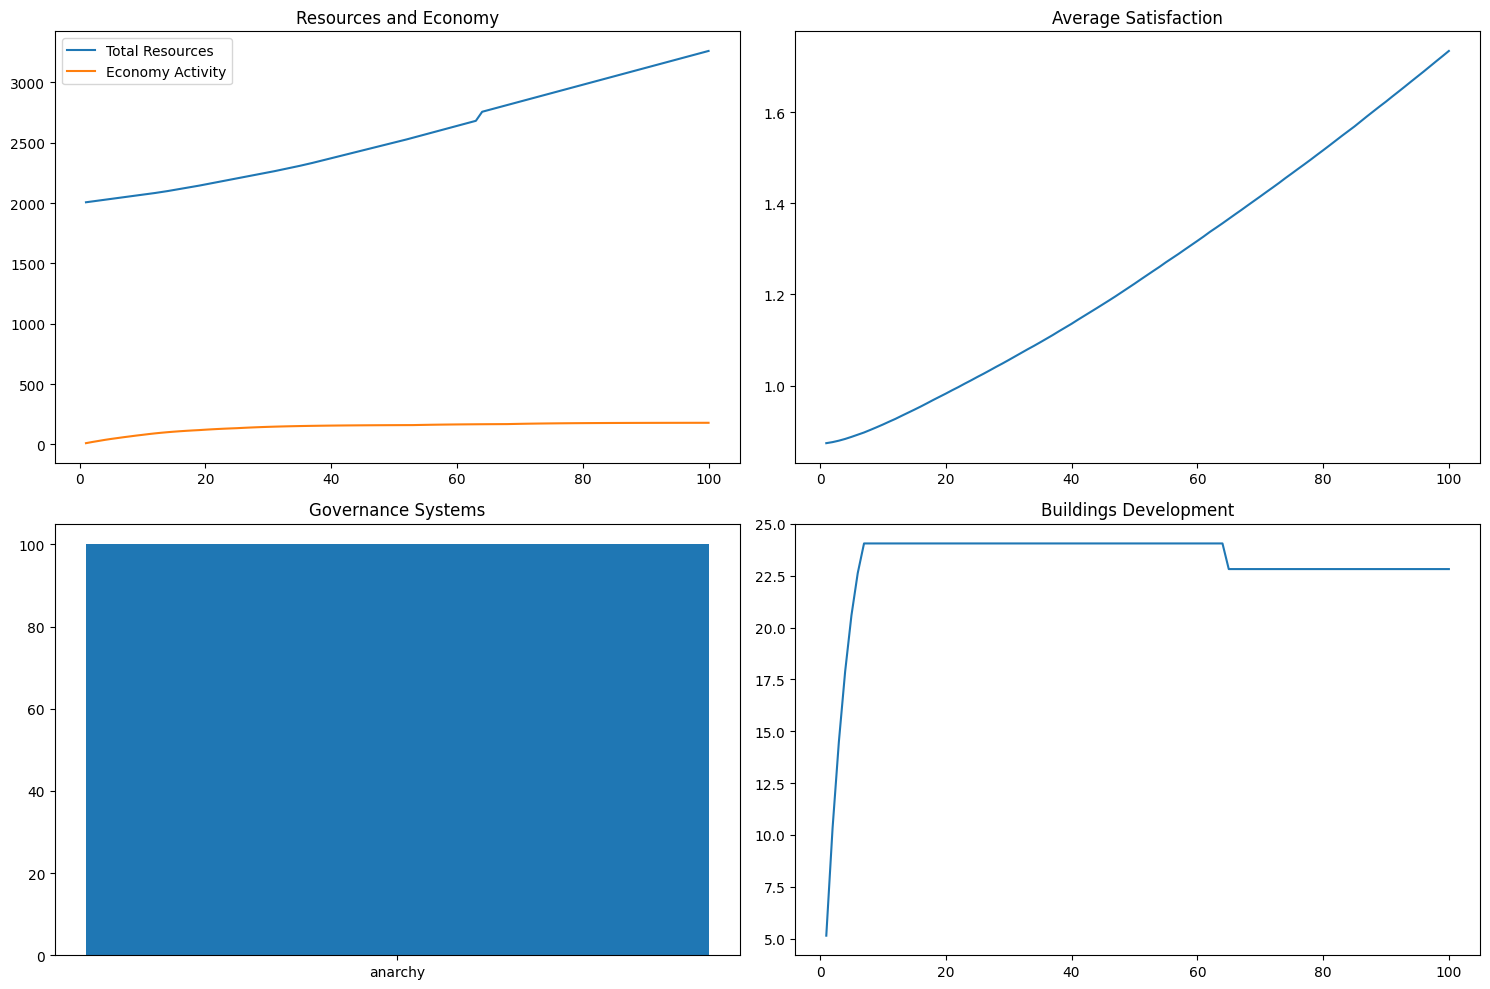

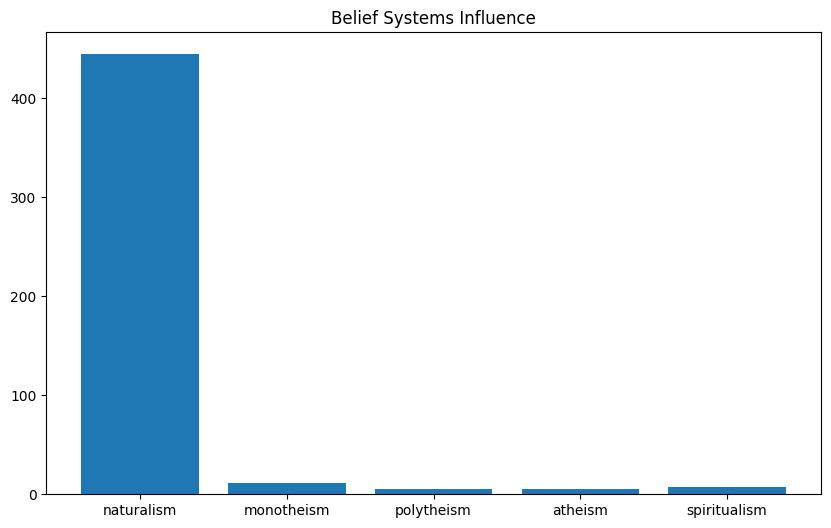

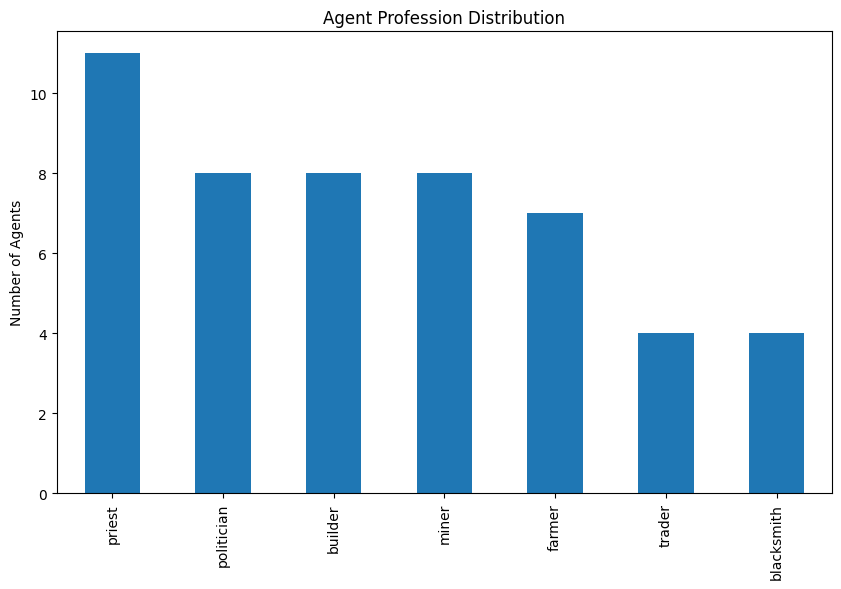


Agent Analysis:
             id      wealth  satisfaction  influence
count  50.00000   50.000000     50.000000  50.000000
mean   24.50000   87.908562      1.734513   6.459557
std    14.57738  130.992670      1.427166  15.038405
min     0.00000   10.000000      0.683500   0.000000
25%    12.25000   36.000000      0.793917   0.000000
50%    24.50000   54.500000      0.862667   0.000000
75%    36.75000   69.000000      3.314750   0.000000
max    49.00000  538.000000      4.508500  48.658622

Example Agents:
Agent 0 (priest):
  Resources: food: 8, wood: 14, stone: 14, metal: 9
  Beliefs: naturalism (1.00)
  Satisfaction: 0.96
Agent 1 (farmer):
  Resources: food: 444, wood: 8, stone: 10, metal: 9
  Beliefs: naturalism (1.00)
  Satisfaction: 4.51
Agent 2 (politician):
  Resources: food: 13, wood: 10, stone: 8, metal: 7
  Beliefs: naturalism (1.00)
  Satisfaction: 0.90
Agent 3 (priest):
  Resources: food: 7, wood: 10, stone: 12, metal: 13
  Beliefs: naturalism (1.00)
  Satisfaction: 0.93
Age

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, defaultdict

# Constants
NUM_AGENTS = 50  # Starting with a smaller number for Colab performance
RESOURCES = ["food", "wood", "stone", "metal"]
PROFESSIONS = ["farmer", "builder", "miner", "blacksmith", "trader", "politician", "priest"]
GOVERNANCE_TYPES = ["democracy", "monarchy", "oligarchy", "anarchy"]
BELIEF_SYSTEMS = ["naturalism", "monotheism", "polytheism", "atheism", "spiritualism"]

class Agent:
    def __init__(self, agent_id):
        self.id = agent_id
        self.name = f"Agent-{agent_id}"
        self.age = random.randint(20, 60)
        self.health = 100
        self.profession = random.choice(PROFESSIONS)
        self.skills = {prof: random.uniform(0, 0.3) if prof != self.profession else random.uniform(0.5, 0.8)
                      for prof in PROFESSIONS}

        # Memory and social attributes
        self.memory = deque(maxlen=50)  # Short-term memory of events
        self.relationships = {}  # Agent ID -> relationship score (-1 to 1)
        self.beliefs = {belief: random.uniform(0, 0.1) for belief in BELIEF_SYSTEMS}
        self.beliefs[random.choice(BELIEF_SYSTEMS)] = random.uniform(0.6, 0.9)  # Strong belief in one system

        # Economic attributes
        self.resources = {resource: random.randint(5, 15) for resource in RESOURCES}
        self.wealth = random.randint(10, 100)
        self.satisfaction = random.uniform(0.4, 0.8)

        # Political attributes
        self.governance_preference = random.choice(GOVERNANCE_TYPES)
        self.leadership = random.uniform(0, 1)
        self.influence = 0

    def update(self, world):
        # Age increases with time
        self.age += 0.1

        # Work based on profession
        self.work(world)

        # Make decisions
        self.make_decisions(world)

        # Update relationships based on interactions
        self.update_relationships(world)

        # Update beliefs
        self.update_beliefs(world)

        # Calculate satisfaction
        self.satisfaction = self.calculate_satisfaction(world)

        # Health decreases with age but can be improved with resources
        self.health = max(0, min(100, self.health - 0.1 + (self.resources["food"] > 5) * 0.05))

        # Add latest world event to memory if available
        if world.events and len(world.events) > 0:
            self.memory.append(world.events[-1])

    def work(self, world):
        # Different professions produce different resources
        if self.profession == "farmer":
            produced = max(1, int(5 * self.skills["farmer"]))
            self.resources["food"] += produced
            world.resources["food"] += produced // 2  # Half goes to community

        elif self.profession == "builder":
            if self.resources["wood"] >= 2:
                self.resources["wood"] -= 2
                world.buildings += self.skills["builder"]

        elif self.profession == "miner":
            produced_stone = max(1, int(4 * self.skills["miner"]))
            produced_metal = max(0, int(2 * self.skills["miner"] * random.uniform(0, 1)))
            self.resources["stone"] += produced_stone
            self.resources["metal"] += produced_metal

        elif self.profession == "blacksmith":
            if self.resources["metal"] >= 1:
                self.resources["metal"] -= 1
                self.wealth += 5 * self.skills["blacksmith"]

        elif self.profession == "trader":
            # Traders increase wealth through exchanges
            trade_amount = max(1, int(5 * self.skills["trader"]))
            self.wealth += trade_amount
            world.economy_activity += trade_amount

        elif self.profession == "politician":
            # Politicians influence governance
            influence_gain = max(0.1, self.skills["politician"] * 0.5)
            self.influence += influence_gain

        elif self.profession == "priest":
            # Priests spread beliefs
            belief_influence = max(0.1, self.skills["priest"] * 0.5)
            strongest_belief = max(self.beliefs, key=self.beliefs.get)
            world.belief_influence[strongest_belief] += belief_influence

    def make_decisions(self, world):
        # Trading decisions
        if self.resources["food"] < 3 and self.wealth > 20:
            # Buy food if low
            food_to_buy = random.randint(3, 5)
            cost = food_to_buy * world.prices["food"]
            if self.wealth >= cost:
                self.wealth -= cost
                self.resources["food"] += food_to_buy
                world.economy_activity += cost

        # Skill improvement
        if random.random() < 0.1:  # 10% chance to learn
            skill_to_improve = self.profession
            self.skills[skill_to_improve] = min(1.0, self.skills[skill_to_improve] + 0.05)

    def update_relationships(self, world):
        # Update relationships with other agents
        for agent in world.agents:
            if agent.id != self.id:
                if agent.id not in self.relationships:
                    self.relationships[agent.id] = random.uniform(-0.2, 0.5)  # Initial impression

                # Similarity in beliefs increases relationship
                belief_similarity = 0
                for belief in BELIEF_SYSTEMS:
                    belief_similarity += 1 - abs(self.beliefs[belief] - agent.beliefs[belief])
                belief_similarity /= len(BELIEF_SYSTEMS)

                # Update relationship
                self.relationships[agent.id] = max(-1, min(1,
                    self.relationships[agent.id] + random.uniform(-0.05, 0.05) + (belief_similarity - 0.5) * 0.1))

    def update_beliefs(self, world):
        # Beliefs can change based on world events and interactions
        strongest_world_belief = max(world.belief_influence, key=world.belief_influence.get)
        world_influence = world.belief_influence[strongest_world_belief] / sum(world.belief_influence.values()) * 0.1

        # Adjust beliefs
        for belief in BELIEF_SYSTEMS:
            # Influenced by world majority with some randomness
            if belief == strongest_world_belief:
                self.beliefs[belief] = min(1.0, self.beliefs[belief] + world_influence + random.uniform(-0.02, 0.05))
            else:
                self.beliefs[belief] = max(0, self.beliefs[belief] - world_influence/2 + random.uniform(-0.02, 0.02))

    def calculate_satisfaction(self, world):
        # Calculate satisfaction based on resources, health, and governance
        resource_satisfaction = sum(self.resources.values()) / (10 * len(self.resources))
        health_satisfaction = self.health / 100

        # Governance satisfaction depends on alignment with current system
        governance_satisfaction = 0.5
        if world.governance_system == self.governance_preference:
            governance_satisfaction = 0.8

        return (resource_satisfaction + health_satisfaction + governance_satisfaction) / 3

class World:
    def __init__(self, num_agents):
        self.agents = [Agent(i) for i in range(num_agents)]
        self.resources = {resource: num_agents * 10 for resource in RESOURCES}
        self.buildings = 0
        self.governance_system = "anarchy"  # Initial governance
        self.governance_scores = {gov: 0 for gov in GOVERNANCE_TYPES}
        self.belief_influence = {belief: 1 for belief in BELIEF_SYSTEMS}
        self.time = 0
        self.economy_activity = 0
        self.prices = {resource: random.uniform(1, 5) for resource in RESOURCES}
        self.events = []
        self.metrics = {
            "time": [],
            "total_resources": [],
            "economy_activity": [],
            "avg_satisfaction": [],
            "governance_system": [],
            "dominant_belief": [],
            "buildings": []
        }

    def update(self):
        self.time += 1

        # Environmental events (random)
        if random.random() < 0.05:  # 5% chance of environmental event
            event_type = random.choice(["drought", "abundance", "disaster", "innovation"])
            if event_type == "drought":
                self.resources["food"] = max(0, self.resources["food"] - random.randint(20, 50))
                self.events.append(f"Time {self.time}: Drought has reduced food supplies")
            elif event_type == "abundance":
                self.resources["food"] += random.randint(30, 80)
                self.events.append(f"Time {self.time}: Abundant harvest has increased food supplies")
            elif event_type == "disaster":
                self.buildings = max(0, self.buildings - random.uniform(0.5, 2.0))
                self.events.append(f"Time {self.time}: A disaster has damaged buildings")
            elif event_type == "innovation":
                profession = random.choice(PROFESSIONS)
                for agent in self.agents:
                    if agent.profession == profession:
                        agent.skills[profession] = min(1.0, agent.skills[profession] + 0.1)
                self.events.append(f"Time {self.time}: Innovation in {profession} has improved skills")

        # Update all agents
        for agent in self.agents:
            agent.update(self)

        # Update governance based on agent preferences and influence
        self.update_governance()

        # Update economy
        self.update_economy()

        # Record metrics
        self.record_metrics()

    def update_governance(self):
        # Reset governance scores
        self.governance_scores = {gov: 0 for gov in GOVERNANCE_TYPES}

        # Calculate scores based on agent preferences and influence
        for agent in self.agents:
            self.governance_scores[agent.governance_preference] += 1 + agent.influence

        # Determine dominant governance system
        dominant_system = max(self.governance_scores, key=self.governance_scores.get)

        # Only change governance if significantly different
        if self.governance_scores[dominant_system] > self.governance_scores[self.governance_system] * 1.2:
            if self.governance_system != dominant_system:
                self.governance_system = dominant_system
                self.events.append(f"Time {self.time}: Governance shifted to {self.governance_system}")

    def update_economy(self):
        # Update prices based on supply and demand
        for resource in RESOURCES:
            # Calculate demand (how many agents need this resource)
            demand = sum(1 for agent in self.agents if agent.resources[resource] < 5)

            # Calculate supply
            supply = self.resources[resource]

            # Update price
            supply_demand_ratio = max(0.1, min(10, supply / (demand + 1)))
            price_change = (0.5 - supply_demand_ratio/10) * random.uniform(0.8, 1.2)
            self.prices[resource] = max(0.5, min(10, self.prices[resource] * (1 + price_change)))

        # Economic activity decay
        self.economy_activity *= 0.9

    def record_metrics(self):
        self.metrics["time"].append(self.time)
        self.metrics["total_resources"].append(sum(self.resources.values()))
        self.metrics["economy_activity"].append(self.economy_activity)
        self.metrics["avg_satisfaction"].append(np.mean([agent.satisfaction for agent in self.agents]))
        self.metrics["governance_system"].append(self.governance_system)
        self.metrics["dominant_belief"].append(max(self.belief_influence, key=self.belief_influence.get))
        self.metrics["buildings"].append(self.buildings)

    def get_metrics_df(self):
        return pd.DataFrame(self.metrics)

    def visualize_metrics(self):
        metrics_df = self.get_metrics_df()

        plt.figure(figsize=(15, 10))

        # Plot 1: Resources and Economy
        plt.subplot(2, 2, 1)
        plt.plot(metrics_df["time"], metrics_df["total_resources"], label="Total Resources")
        plt.plot(metrics_df["time"], metrics_df["economy_activity"], label="Economy Activity")
        plt.title("Resources and Economy")
        plt.legend()

        # Plot 2: Satisfaction
        plt.subplot(2, 2, 2)
        plt.plot(metrics_df["time"], metrics_df["avg_satisfaction"])
        plt.title("Average Satisfaction")

        # Plot 3: Governance System
        plt.subplot(2, 2, 3)
        governance_data = metrics_df["governance_system"].value_counts().sort_index()
        plt.bar(governance_data.index, governance_data.values)
        plt.title("Governance Systems")

        # Plot 4: Buildings
        plt.subplot(2, 2, 4)
        plt.plot(metrics_df["time"], metrics_df["buildings"])
        plt.title("Buildings Development")

        plt.tight_layout()
        plt.show()

        # Plot beliefs influence
        plt.figure(figsize=(10, 6))
        belief_values = [self.belief_influence[belief] for belief in BELIEF_SYSTEMS]
        plt.bar(BELIEF_SYSTEMS, belief_values)
        plt.title("Belief Systems Influence")
        plt.show()

    def agent_distribution(self):
        professions = [agent.profession for agent in self.agents]
        prof_counts = pd.Series(professions).value_counts()

        plt.figure(figsize=(10, 6))
        prof_counts.plot(kind='bar')
        plt.title("Agent Profession Distribution")
        plt.ylabel("Number of Agents")
        plt.show()

# Training and simulation runner
def run_simulation(num_agents=NUM_AGENTS, iterations=100):
    world = World(num_agents)

    # Run the simulation
    for i in range(iterations):
        if i % 10 == 0:
            clear_output(wait=True)
            print(f"Running simulation: {i}/{iterations} iterations")

            # Print some stats
            resources_summary = ", ".join([f"{r}: {world.resources[r]:.1f}" for r in RESOURCES])
            print(f"World resources: {resources_summary}")
            print(f"Governance: {world.governance_system}")
            print(f"Dominant belief: {max(world.belief_influence, key=world.belief_influence.get)}")
            print(f"Buildings: {world.buildings:.1f}")
            print(f"Average satisfaction: {np.mean([agent.satisfaction for agent in world.agents]):.2f}")

            # Print latest events
            print("\nLatest events:")
            for event in world.events[-5:]:
                print(f"- {event}")

        world.update()

    clear_output(wait=True)
    print("Simulation complete!")

    # Visualize metrics
    world.visualize_metrics()
    world.agent_distribution()

    # Agent analysis
    agent_data = []
    for agent in world.agents:
        agent_data.append({
            "id": agent.id,
            "profession": agent.profession,
            "governance_preference": agent.governance_preference,
            "strongest_belief": max(agent.beliefs, key=agent.beliefs.get),
            "wealth": agent.wealth,
            "satisfaction": agent.satisfaction,
            "influence": agent.influence
        })

    agent_df = pd.DataFrame(agent_data)
    print("\nAgent Analysis:")
    print(agent_df.describe())

    # Show some example agents
    print("\nExample Agents:")
    for i in range(min(5, len(world.agents))):
        agent = world.agents[i]
        print(f"Agent {agent.id} ({agent.profession}):")
        print(f"  Resources: {', '.join([f'{r}: {v}' for r, v in agent.resources.items()])}")
        print(f"  Beliefs: {max(agent.beliefs, key=agent.beliefs.get)} ({agent.beliefs[max(agent.beliefs, key=agent.beliefs.get)]:.2f})")
        print(f"  Satisfaction: {agent.satisfaction:.2f}")

    return world

# Neural network model for more complex agent decision making (optional extension)
class AgentNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(AgentNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Code to run in Google Colab
if __name__ == "__main__":
    # Run a shorter simulation for Colab
    world = run_simulation(num_agents=50, iterations=100)